In [1]:
## Python 3.8.16
# ! pip install matplotlib
# ! pip install pandas
# ! pip install seaborn
# ! pip install -U pip setuptools wheel
# ! pip install -U 'spacy[cuda-autodetect]'
# ! python -m spacy download es_core_news_sm
# ! pip install spacy-cleaner
# ! pip install ydata-profiling

In [2]:
%matplotlib inline
import spacy
import numpy as np
import pandas as pd
import spacy_cleaner
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from spacy.tokenizer import Tokenizer
from ydata_profiling import ProfileReport
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy_cleaner.processing import removers, replacers, mutators
pd.options.mode.chained_assignment = None

/home/oscar/anaconda3/envs/text/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Análisis exploratorio marketplace

Los datos vienen con un pequeño tratamiento para extraer campos de columnas con doble valor, posteriormente a este análisis se complementara esta parte, en esta etapa se dará prioridad a la velocidad y posteriormente en el código 
de ETL se refinara el código para poder replicar con otros conjuntos de datos los archivos, por otro lado los resultados de EDA se ecuentran en los archivos: **output_initial.html**, **output_clean.html** y **output_initial.html**, del directorio raíz de este repositorio 

In [3]:
FOLDER = "/home/oscar/GitHub/test_used_tl_ML/data/"

In [4]:
df = pd.read_csv(FOLDER + "train.csv", index_col=0)
df = df.reset_index(drop=True)

/tmp/ipykernel_458704/1023102910.py:1: DtypeWarning: Columns (6,10,14,24,25,26,30,32,38,41,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FOLDER + "train.csv", index_col=0)


In [5]:
print(f"Cantidad de variables {len(df.columns)}, cantidad de observaciones {len(df)}")

Cantidad de variables 47, cantidad de observaciones 100003


### Perfilado inicial

In [6]:
profile = ProfileReport(df, minimal=True)
profile.to_file("output_initial.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 441.78it/s]


En esta parte se definen las variables mas importantes según el análisis del perfilador utilizado, en la parte siguiente de este informe solo se trataran las variables que tiene una cardinalidad baja, que el desequilibrio en las clases no sea mayor al 50% y que los valores faltantes no superen el 10%, así mismo las variables no soportadas se les hará un tratamiento de limpieza mas admitido y al final se compararan los dos análisis

### Limpieza posterior de las variables no soportadas

#### Variable seller_id

In [7]:
df["seller_id"].head()

0    8208882349
1    8141699488
2    8386096505
3    5377752182
4    2938071313
Name: seller_id, dtype: object

In [8]:
df["seller_id"].describe()

count          99999
unique         43154
top       5248662274
freq             618
Name: seller_id, dtype: int64

**Nota:** Esta columna para ce que para el objetivo del análisis de determinar si el carro ofrecido es nuevo o usado para ce que tiene poco valor ya que es un identificador de usuario, pero para campañas de marketing de los 90.000 datos analizados hay únicos 39.432, es decir que hay una población de vendedores por lo menos de mas de una venta, se procede a eliminar del análisis preliminar

In [9]:
na_seller_id = df[df["seller_id"].isnull() == True]
na_seller_id

,warranty,sub_status,condition,deal_ids,base_price,seller_id,variations,site_id,listing_type_id,price,...,start_time,permalink,sold_quantity,available_quantity,seller_address_country_name,seller_address_state_name,seller_address_city_name,shipping_local_pick_up,shipping_free_shipping,Y
16693,Envios a capital federal $26.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83019,4 meses de Garantía,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83841,Envios capital federeal $26.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93111,Envios a capital federal $33.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
na_seller_id = list(na_seller_id.index)

In [11]:
df = df.drop(na_seller_id, axis=0)

In [12]:
df = df.drop("seller_id", axis=1)

#### Variable price

In [13]:
df["price"].tail()

99998     417.99
99999       30.0
100000     239.0
100001     600.0
100002      50.0
Name: price, dtype: object

In [14]:
df["price"].describe()

count     99999.0
unique    12824.0
top          50.0
freq       2172.0
Name: price, dtype: float64

In [15]:
na_price = df[df["price"].isnull() == True]
na_price

,warranty,sub_status,condition,deal_ids,base_price,variations,site_id,listing_type_id,price,attributes,...,start_time,permalink,sold_quantity,available_quantity,seller_address_country_name,seller_address_state_name,seller_address_city_name,shipping_local_pick_up,shipping_free_shipping,Y


In [16]:
df["temp_column_price"] = df["price"].apply(lambda x: type(x) != float)

In [17]:
type(df["price"][df["temp_column_price"] == True].iloc[0])

str

In [18]:
for i in range(len(df)):
    if df["temp_column_price"].iloc[i] == True:
        try:
            df["price"].iloc[i] = float(df["price"].iloc[i])
        except:
            df["price"].iloc[i] = float("nan")

In [19]:
na_price = df[df["price"].isnull() == True]
na_price

,warranty,sub_status,condition,deal_ids,base_price,variations,site_id,listing_type_id,price,attributes,...,permalink,sold_quantity,available_quantity,seller_address_country_name,seller_address_state_name,seller_address_city_name,shipping_local_pick_up,shipping_free_shipping,Y,temp_column_price
16694,[],used,[],80.0,9.357516e+09,MLA,bronze,80.0,NaN,buy_it_now,...,0,1.0,Argentina,Capital Federal,tribunales,False,False,used,NaN,True
83020,[],new,[],5500.0,8.714872e+09,MLA,bronze,5500.0,NaN,buy_it_now,...,0,1.0,Argentina,Capital Federal,Almagro,False,False,new,NaN,True
83842,[],new,[],100.0,9.357516e+09,MLA,bronze,100.0,NaN,buy_it_now,...,0,1.0,Argentina,Capital Federal,tribunales,True,False,new,NaN,True
93112,[],used,[],70.0,9.357516e+09,MLA,bronze,70.0,NaN,buy_it_now,...,0,1.0,Argentina,Capital Federal,tribunales,False,False,used,NaN,True


In [20]:
na_price = list(na_price.index)

In [21]:
df = df.drop(na_price, axis=0)

In [22]:
max(df["price"]), min(df["price"])

(2222222222.0, 0.84)

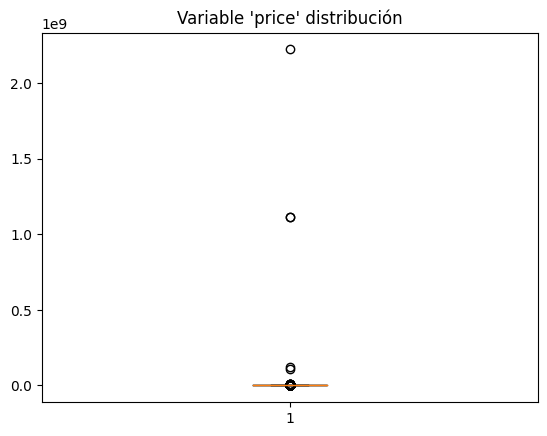

In [23]:
plt.boxplot(df["price"])
plt.title("Variable 'price' distribución")
plt.show()

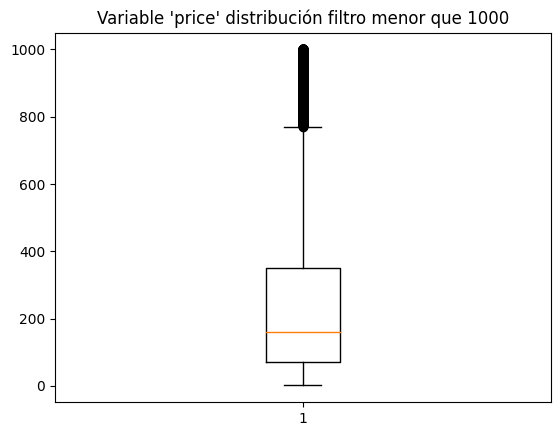

In [24]:
plt.boxplot(df["price"][df["price"] < 1000])
plt.title("Variable 'price' distribución filtro menor que 1000")
plt.show()

In [25]:
len(df["price"][df["price"] < 10000])

95955

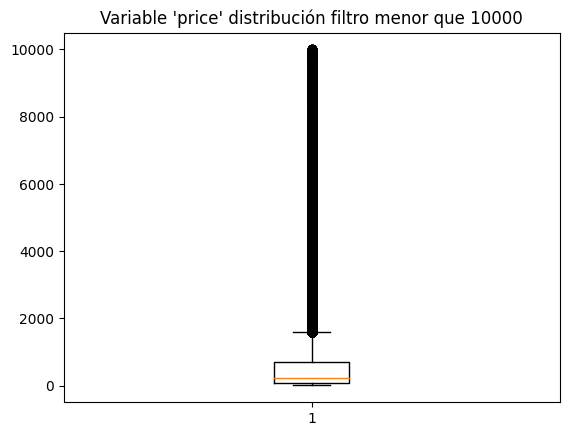

In [26]:
plt.boxplot(df["price"][df["price"] < 10000])
plt.title("Variable 'price' distribución filtro menor que 10000")
plt.show()

In [27]:
(1 - len(df["price"][df["price"] < 10000]) / len(df)) * 100

4.0402020101005025

**Nota :** Esta columna presenta varios valore atípicos por esta razón se procede a eliminar los valores que estén por encima de 100.000, perdiendo solo el 4% de los datos originales, al valor mayor es de 2.222.222.222 que es muy atípico

In [28]:
df = df[df["price"] < 10000]

In [29]:
len(df)

95955

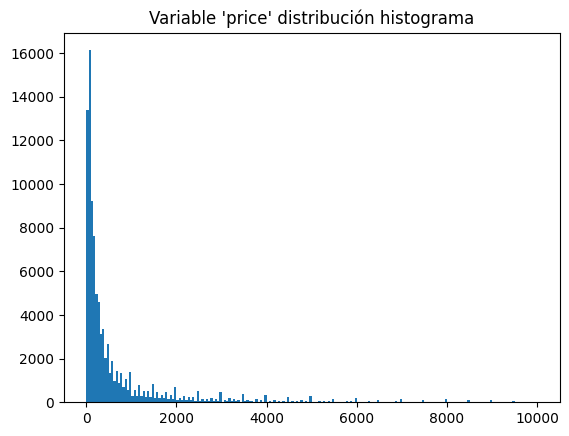

In [30]:
plt.hist(df["price"], bins=200)
plt.title("Variable 'price' distribución histograma")
plt.show()

#### Variable original price

In [31]:
df["original_price"].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: original_price, dtype: object

In [32]:
na_original_price = df[df["original_price"].isnull() == True]
na_original_price

,warranty,sub_status,condition,deal_ids,base_price,variations,site_id,listing_type_id,price,attributes,...,permalink,sold_quantity,available_quantity,seller_address_country_name,seller_address_state_name,seller_address_city_name,shipping_local_pick_up,shipping_free_shipping,Y,temp_column_price
0,NaN,[],new,[],80.00,[],MLA,bronze,80.0,[],...,http://articulo.mercadolibre.com.ar/MLA4695330...,0.0,1,Argentina,Capital Federal,San Cristóbal,True,False,new,False
1,NUESTRA REPUTACION,[],used,[],2650.00,[],MLA,silver,2650.0,[],...,http://articulo.mercadolibre.com.ar/MLA7160447...,0.0,1,Argentina,Capital Federal,Buenos Aires,True,False,used,False
2,NaN,[],used,[],60.00,[],MLA,bronze,60.0,[],...,http://articulo.mercadolibre.com.ar/MLA7367189...,0.0,1,Argentina,Capital Federal,Boedo,True,False,used,False
3,NaN,[],new,[],580.00,[],MLA,silver,580.0,[],...,http://articulo.mercadolibre.com.ar/MLA9191625...,0.0,1,Argentina,Capital Federal,Floresta,True,False,new,False
4,MI REPUTACION.,[],used,[],30.00,[],MLA,bronze,30.0,[],...,http://articulo.mercadolibre.com.ar/MLA7787961...,0.0,1,Argentina,Buenos Aires,Tres de febrero,True,False,used,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99998,SI,[],new,[],417.99,[],MLA,bronze,417.99,[],...,http://articulo.mercadolibre.com.ar/MLA4006670...,0.0,2,Argentina,Buenos Aires,Avellaneda,True,False,new,False
99999,NaN,[],used,[],30.00,[],MLA,free,30.0,[],...,http://articulo.mercadolibre.com.ar/MLA7015262...,0.0,1,Argentina,Buenos Aires,Don Torcuato,True,False,used,False
100000,NaN,[],new,[],239.00,[],MLA,bronze,239.0,[],...,http://articulo.mercadolibre.com.ar/MLA6831230...,0.0,5,Argentina,Buenos Aires,Lomas de Zamora,False,False,new,False
100001,NaN,[],used,[],600.00,[{'attribute_combinations': [{'value_id': '920...,MLA,bronze,600.0,"[{'value_id': 'male', 'attribute_group_id': 'D...",...,http://articulo.mercadolibre.com.ar/MLA4632330...,0.0,1,Argentina,Buenos Aires,Morón,False,False,used,False


**Nota:** Esta variable tiene todos su valores NA así que se procede a eliminar

In [33]:
df = df.drop(["original_price", "temp_column_price"], axis=1)

#### Variable automatic_relist

In [34]:
df["automatic_relist"].head()

0    False
1    False
2    False
3    False
4    False
Name: automatic_relist, dtype: object

In [35]:
df["automatic_relist"] = df["automatic_relist"].apply(lambda x: type(x) != bool)
for i in range(len(df)):
    if df["automatic_relist"].iloc[i] == True:
        try:
            df["automatic_relist"].iloc[i] = float(df["automatic_relist"].iloc[i])
        except:
            df["automatic_relist"].iloc[i] = float("nan")

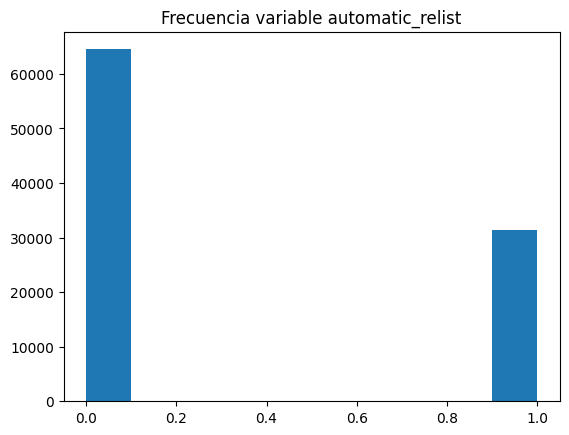

In [36]:
plt.hist(df["automatic_relist"])
plt.title("Frecuencia variable automatic_relist")
plt.show()

In [37]:
na_automatic_relist = df[df["automatic_relist"].isnull() == True]
na_automatic_relist

,warranty,sub_status,condition,deal_ids,base_price,variations,site_id,listing_type_id,price,attributes,...,start_time,permalink,sold_quantity,available_quantity,seller_address_country_name,seller_address_state_name,seller_address_city_name,shipping_local_pick_up,shipping_free_shipping,Y


**Nota:** Esta variable esta des balanceada pero se tendrá en cuenta en el análisis inicial 

#### Variable stop_time y start_time

In [38]:
df["stop_time"].head()

0    1446669773000
1    1448474910000
2    1447027027000
3    1449191596000
4    1445638040000
Name: stop_time, dtype: object

In [39]:
df["start_time"].head()

0    1441485773000
1    1443290910000
2    1441843027000
3    1443466076000
4    1440454040000
Name: start_time, dtype: object

**Nota:** Esta variable es una marca de tiempo y el problema es de clasificación así que no se tendrán en cuenta y se eliminaran de este análisis

In [40]:
df = df.drop(["stop_time", "start_time"], axis=1)

#### Variable available_quantity

In [41]:
df["available_quantity"].head()

0    1
1    1
2    1
3    1
4    1
Name: available_quantity, dtype: object

In [42]:
df["available_quantity"] = df["available_quantity"].apply(lambda x: type(x) != int)
for i in range(len(df)):
    if df["available_quantity"].iloc[i] == True:
        try:
            df["available_quantity"].iloc[i] = float(df["available_quantity"].iloc[i])
        except:
            df["available_quantity"].iloc[i] = float("nan")

In [43]:
na_available_quantity = df[df["available_quantity"].isnull() == True]
na_available_quantity

,warranty,sub_status,condition,deal_ids,base_price,variations,site_id,listing_type_id,price,attributes,...,initial_quantity,permalink,sold_quantity,available_quantity,seller_address_country_name,seller_address_state_name,seller_address_city_name,shipping_local_pick_up,shipping_free_shipping,Y


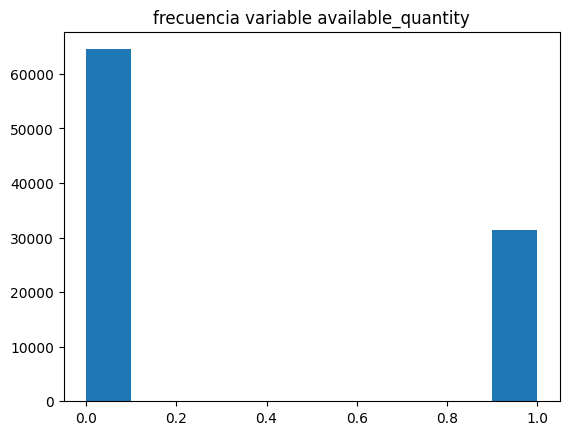

In [44]:
plt.hist(df["available_quantity"])
plt.title("frecuencia variable available_quantity")
plt.show()

**Nota:** Esta variable esta des balanceada pero se tendrá en cuenta en el análisis inicial 

#### Variable shipping_free_shipping

In [45]:
df["shipping_free_shipping"].head()

0    False
1    False
2    False
3    False
4    False
Name: shipping_free_shipping, dtype: object

In [46]:
df["shipping_free_shipping"] = df["shipping_free_shipping"].apply(lambda x: type(x) != int)
for i in range(len(df)):
    if df["shipping_free_shipping"].iloc[i] == True:
        try:
            df["shipping_free_shipping"].iloc[i] = float(df["shipping_free_shipping"].iloc[i])
        except:
            df["shipping_free_shipping"].iloc[i] = float("nan")

In [47]:
na_shipping_free_shipping = df[df["shipping_free_shipping"].isnull() == True]
na_shipping_free_shipping

,warranty,sub_status,condition,deal_ids,base_price,variations,site_id,listing_type_id,price,attributes,...,initial_quantity,permalink,sold_quantity,available_quantity,seller_address_country_name,seller_address_state_name,seller_address_city_name,shipping_local_pick_up,shipping_free_shipping,Y


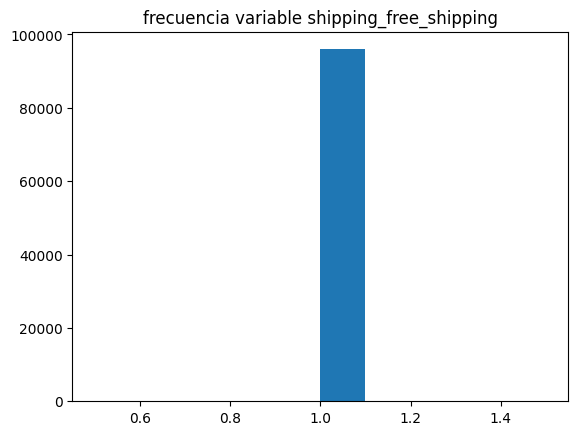

In [48]:
plt.hist(df["shipping_free_shipping"])
plt.title("frecuencia variable shipping_free_shipping")
plt.show()

**Nota:** Esta variable tiene todos su valores igual a 1 así que se procede a eliminar

In [49]:
df = df.drop(["shipping_free_shipping"], axis=1)

#### Variable warranty

Esta es una variable de tipo categórica, pero se quiere mejorar su desempeño con algo de tratamiento de texto, transformando todo el texto a minúscula y quitando los acentos con el fin de reducir las categorías

In [50]:
df["warranty"] = df["warranty"].apply(lambda x: str(x).lower())

In [51]:
def remove_accents(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

In [52]:
df["warranty"] = df["warranty"].apply(lambda x: remove_accents(x))

In [53]:
df = df.drop("warranty", axis=1)

**Nota:** Esta variable tiene todos su valores NA así que se procede a eliminar

#### Variable official_store_id

In [54]:
df["official_store_id"] = df["official_store_id"].astype(str)

**Nota:** Esta variable en realidad es categórica se hace la transformación respectiva

### Perfilado posterior a la limpieza

In [55]:
profile = ProfileReport(df, minimal=True)
profile.to_file("output_clean.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 477.98it/s]


**Nota:** Con esta limpieza posterior mas especifica de variables las alertas se redujeron a de 53 a 44 los valores no procesables, se prosiguen analizando las variables para tener el mejor pre procesamiento

#### Variable listing_source 

In [56]:
df["listing_source"].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: listing_source, dtype: object

In [57]:
na_listing_source = df[df["listing_source"].isnull() == True]
na_listing_source

,sub_status,condition,deal_ids,base_price,variations,site_id,listing_type_id,price,attributes,buying_mode,...,subtitle,initial_quantity,permalink,sold_quantity,available_quantity,seller_address_country_name,seller_address_state_name,seller_address_city_name,shipping_local_pick_up,Y
0,[],new,[],80.00,[],MLA,bronze,80.0,[],buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA4695330...,0.0,False,Argentina,Capital Federal,San Cristóbal,True,new
1,[],used,[],2650.00,[],MLA,silver,2650.0,[],buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA7160447...,0.0,False,Argentina,Capital Federal,Buenos Aires,True,used
2,[],used,[],60.00,[],MLA,bronze,60.0,[],buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA7367189...,0.0,False,Argentina,Capital Federal,Boedo,True,used
3,[],new,[],580.00,[],MLA,silver,580.0,[],buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA9191625...,0.0,False,Argentina,Capital Federal,Floresta,True,new
4,[],used,[],30.00,[],MLA,bronze,30.0,[],buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA7787961...,0.0,False,Argentina,Buenos Aires,Tres de febrero,True,used
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99998,[],new,[],417.99,[],MLA,bronze,417.99,[],buy_it_now,...,NaN,2.0,http://articulo.mercadolibre.com.ar/MLA4006670...,0.0,False,Argentina,Buenos Aires,Avellaneda,True,new
99999,[],used,[],30.00,[],MLA,free,30.0,[],buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA7015262...,0.0,False,Argentina,Buenos Aires,Don Torcuato,True,used
100000,[],new,[],239.00,[],MLA,bronze,239.0,[],buy_it_now,...,NaN,5.0,http://articulo.mercadolibre.com.ar/MLA6831230...,0.0,False,Argentina,Buenos Aires,Lomas de Zamora,False,new
100001,[],used,[],600.00,[{'attribute_combinations': [{'value_id': '920...,MLA,bronze,600.0,"[{'value_id': 'male', 'attribute_group_id': 'D...",buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA4632330...,0.0,False,Argentina,Buenos Aires,Morón,False,used


In [58]:
df = df.drop("listing_source", axis=1)

**Nota:** Esta variable tiene todos su valores NA así que se procede a eliminar

#### Variable diferential_pricing

In [59]:
df["differential_pricing"].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: differential_pricing, dtype: object

In [60]:
na_differential_pricing = df[df["differential_pricing"].isnull() == True]
na_differential_pricing

,sub_status,condition,deal_ids,base_price,variations,site_id,listing_type_id,price,attributes,buying_mode,...,subtitle,initial_quantity,permalink,sold_quantity,available_quantity,seller_address_country_name,seller_address_state_name,seller_address_city_name,shipping_local_pick_up,Y
0,[],new,[],80.00,[],MLA,bronze,80.0,[],buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA4695330...,0.0,False,Argentina,Capital Federal,San Cristóbal,True,new
1,[],used,[],2650.00,[],MLA,silver,2650.0,[],buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA7160447...,0.0,False,Argentina,Capital Federal,Buenos Aires,True,used
2,[],used,[],60.00,[],MLA,bronze,60.0,[],buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA7367189...,0.0,False,Argentina,Capital Federal,Boedo,True,used
3,[],new,[],580.00,[],MLA,silver,580.0,[],buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA9191625...,0.0,False,Argentina,Capital Federal,Floresta,True,new
4,[],used,[],30.00,[],MLA,bronze,30.0,[],buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA7787961...,0.0,False,Argentina,Buenos Aires,Tres de febrero,True,used
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99998,[],new,[],417.99,[],MLA,bronze,417.99,[],buy_it_now,...,NaN,2.0,http://articulo.mercadolibre.com.ar/MLA4006670...,0.0,False,Argentina,Buenos Aires,Avellaneda,True,new
99999,[],used,[],30.00,[],MLA,free,30.0,[],buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA7015262...,0.0,False,Argentina,Buenos Aires,Don Torcuato,True,used
100000,[],new,[],239.00,[],MLA,bronze,239.0,[],buy_it_now,...,NaN,5.0,http://articulo.mercadolibre.com.ar/MLA6831230...,0.0,False,Argentina,Buenos Aires,Lomas de Zamora,False,new
100001,[],used,[],600.00,[{'attribute_combinations': [{'value_id': '920...,MLA,bronze,600.0,"[{'value_id': 'male', 'attribute_group_id': 'D...",buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA4632330...,0.0,False,Argentina,Buenos Aires,Morón,False,used


In [61]:
df = df.drop("differential_pricing", axis=1)

**Nota:** Esta variable tiene todos su valores NA así que se procede a eliminar

#### Variable subtitle

In [62]:
df["subtitle"].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: subtitle, dtype: float64

In [63]:
na_subtitle = df[df["subtitle"].isnull() == True]
na_subtitle

,sub_status,condition,deal_ids,base_price,variations,site_id,listing_type_id,price,attributes,buying_mode,...,subtitle,initial_quantity,permalink,sold_quantity,available_quantity,seller_address_country_name,seller_address_state_name,seller_address_city_name,shipping_local_pick_up,Y
0,[],new,[],80.00,[],MLA,bronze,80.0,[],buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA4695330...,0.0,False,Argentina,Capital Federal,San Cristóbal,True,new
1,[],used,[],2650.00,[],MLA,silver,2650.0,[],buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA7160447...,0.0,False,Argentina,Capital Federal,Buenos Aires,True,used
2,[],used,[],60.00,[],MLA,bronze,60.0,[],buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA7367189...,0.0,False,Argentina,Capital Federal,Boedo,True,used
3,[],new,[],580.00,[],MLA,silver,580.0,[],buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA9191625...,0.0,False,Argentina,Capital Federal,Floresta,True,new
4,[],used,[],30.00,[],MLA,bronze,30.0,[],buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA7787961...,0.0,False,Argentina,Buenos Aires,Tres de febrero,True,used
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99998,[],new,[],417.99,[],MLA,bronze,417.99,[],buy_it_now,...,NaN,2.0,http://articulo.mercadolibre.com.ar/MLA4006670...,0.0,False,Argentina,Buenos Aires,Avellaneda,True,new
99999,[],used,[],30.00,[],MLA,free,30.0,[],buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA7015262...,0.0,False,Argentina,Buenos Aires,Don Torcuato,True,used
100000,[],new,[],239.00,[],MLA,bronze,239.0,[],buy_it_now,...,NaN,5.0,http://articulo.mercadolibre.com.ar/MLA6831230...,0.0,False,Argentina,Buenos Aires,Lomas de Zamora,False,new
100001,[],used,[],600.00,[{'attribute_combinations': [{'value_id': '920...,MLA,bronze,600.0,"[{'value_id': 'male', 'attribute_group_id': 'D...",buy_it_now,...,NaN,1.0,http://articulo.mercadolibre.com.ar/MLA4632330...,0.0,False,Argentina,Buenos Aires,Morón,False,used


In [64]:
df = df.drop("subtitle", axis=1)

### Variables a eliminar por una alta cardinalidad, valor único o un des balanceo mayor

En el informe output_clean.html de este repositorio están los valores y la explicación mas detallada consultar si se tiene alguna duda el archivo se puede abrir sin problema en cualquier navegador

In [65]:
drop_columns = ["sub_status", # esta variable tiene 85.496 valores "[]"
                "deal_ids", # esta variable tiene 86.154 valores "[]"
                "variations", # esta variable tiene 78.997 valores "[]"
                "site_id", # Todos los valores son MLA
                "attributes", # esta variable tiene 77.005 valores "[]"
                "buying_mode", # esta variable tiene 85.496 valores "buy_it_now"
                "parent_item_id", # esta variable tiene muy alta cardinalidad
                "coverage_areas", # todos los valores con "[]"
                "last_updated", # esta variable es de tipo date
                "international_delivery_mode", # todos los valores son none
                "pictures", # se eliminará pues son links a imagenes y nos estan disponibles, para el futuro se puede contemplar imagénes para determinar si es nuevo o usado 
                "id", # esta variable es un identificador único
                "accepts_mercadopago", # esta variable tiene 86.146 valores "True"
                "currency_id", # esta variable tiene 86.347 valores "True"
                "thumbnail", # son imagenes interesante para analisis posteriores 
                "date_created", # este valor es detipo date 
                "status", # esta variable tiene 86.146 valores "active"
                "video_id", # esta variable son id de videos que no son útiles para analizar
                "catalog_product_id", # esta variable es un identificador
                "permalink", # link de la publicación
                "sold_quantity", # todos los valores son 0
                "seller_address_country_name", # todos los valores son iguales a Argentina
                "shipping_local_pick_up", # # esta variable tiene 70.015 valores "True"                
                "initial_quantity", # el 95% de los valores son 0
                "condition", # es la variable objetivo
                "official_store_id", # # esta variable tiene 85.638 valores NAN
                "base_price", # esta variable tiene la misma desviación estandar,la media y el cv de price
                "category_id", # esta varaible tiene mas de 9926 categorias unicas
                "automatic_relist", # esta variable tiene los mismos valores que "available_quantity"
                "tags", # el 74.4 de los valores son ['dragged_bids_and_visits']
                "descriptions" # inicialmente se pensó que tenia texto para analizar pero son solo identificadores
                ]

In [66]:
df = df.drop(drop_columns, axis=1)

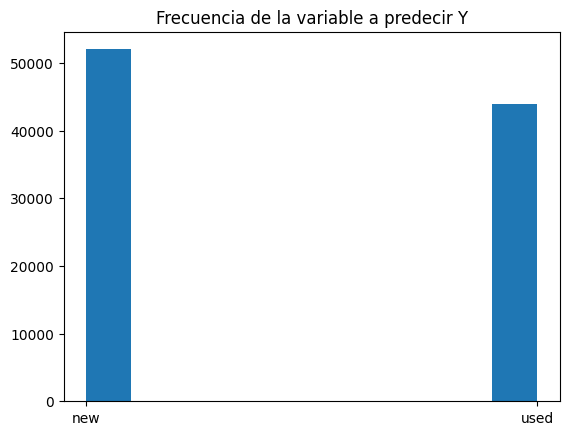

In [67]:
plt.hist(df["Y"])
plt.title("Frecuencia de la variable a predecir Y")
plt.show()

In [68]:
profile = ProfileReport(df, minimal=True)
profile.to_file("output_final.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 948.72it/s]


In [69]:
print(f"Cantidad de variables {len(df.columns)}, cantidad de observaciones {len(df)}")

Cantidad de variables 7, cantidad de observaciones 95955


## Variables a utilizar en el análisis 

En este ejercicio de preparación de los datos se redujo de **47** variables a **7** y se redujo la cantidad de datos de **100003** a **95955** es decir redujeron las observaciones de **4,04%**, el resultado del análisis exploratorio en su etapa inicial, con la limpieza de variables y el final se encuentran en los archivos: *output_initial.html*, *output_clean.html* y *output_initial.html*, del directorio raíz de este repositorio

### Exploraciones adicionales

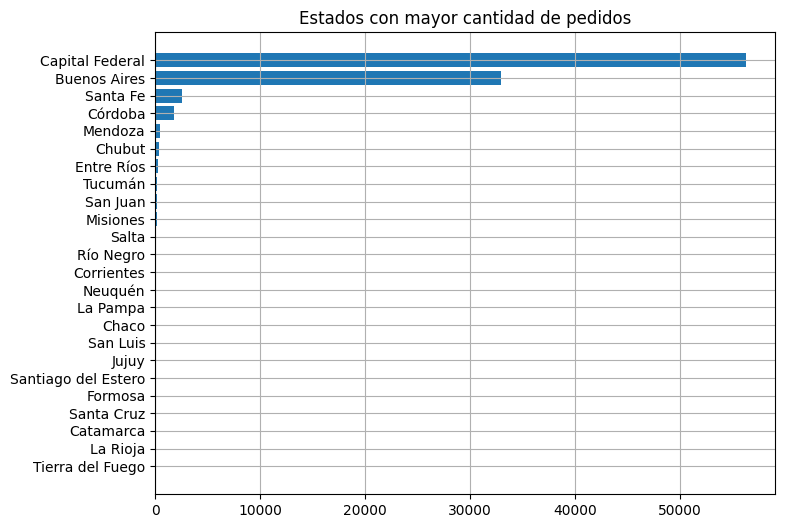

In [70]:
plt.figure(figsize=(8, 6))
df_seller_address_state_name = df.groupby("seller_address_state_name").agg({"seller_address_state_name": "count"})
df_seller_address_state_name = df_seller_address_state_name.rename(columns={"seller_address_state_name": "Estado"})
df_seller_address_state_name = df_seller_address_state_name.sort_values("Estado")
plt.barh(list(df_seller_address_state_name.index), df_seller_address_state_name["Estado"])
plt.title("Estados con mayor cantidad de pedidos")
plt.grid()
plt.show()

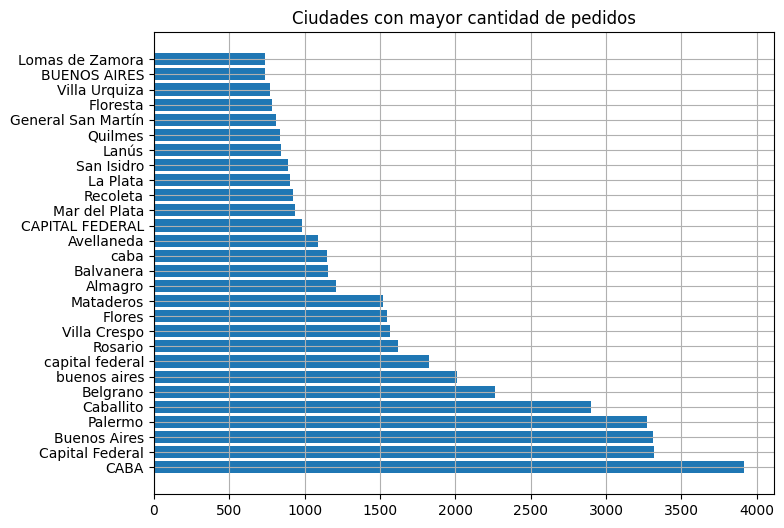

In [71]:
plt.figure(figsize=(8, 6))
df_seller_address_state_name = df.groupby("seller_address_city_name").agg({"seller_address_city_name": "count"})
df_seller_address_state_name = df_seller_address_state_name.rename(columns={"seller_address_city_name": "Ciudad"})
df_seller_address_state_name = df_seller_address_state_name.sort_values("Ciudad", ascending=False)
df_seller_address_state_name = df_seller_address_state_name[0:28]
plt.barh(list(df_seller_address_state_name.index), df_seller_address_state_name["Ciudad"])
plt.title("Ciudades con mayor cantidad de pedidos")
plt.grid()
plt.show()

## Análisis de componentes principales y correlación

Para continuar con nuestro análisis, es importante realizar el tratamiento de normalización y creación de variables dummies. Sin embargo, vamos a separar la variable 'title' del resto de variables, ya que planeamos aplicar técnicas de Procesamiento de Lenguaje Natural (NLP) específicamente en ella. Mientras tanto, seguiremos el enfoque tradicional con las demás variables.

Nuestra hipótesis en este punto es complementar la distribución de probabilidad de un clasificador binario de texto con un clasificador binario tradicional. Esto nos permitirá obtener una visión más completa del comportamiento del problema en estudio.

Además, utilizaremos el Análisis de Componentes Principales (PCA) para obtener una visión global inicial del problema y comprender mejor su estructura y patrones subyacentes.

Igualmente las variables 'seller_address_state_name', 'seller_address_city_name' no se tendran en cuanta por su naturaleza de ser una clase donde se envian los pedidios

In [72]:
df.columns

Index(['listing_type_id', 'price', 'title', 'available_quantity',
       'seller_address_state_name', 'seller_address_city_name', 'Y'],
      dtype='object')

In [73]:
df_num = df[['listing_type_id', 'price', 'available_quantity', 'Y']]

In [74]:
df_text = df[["title", "Y"]]

### Preparación variables numéricas para PCA

In [75]:
df_num.head()

,listing_type_id,price,available_quantity,Y
0,bronze,80.0,False,new
1,silver,2650.0,False,used
2,bronze,60.0,False,used
3,silver,580.0,False,new
4,bronze,30.0,False,used


In [76]:
df_num_d = pd.get_dummies(df_num[["listing_type_id", "available_quantity", "Y"]])

In [77]:
df_num_d.columns

Index(['listing_type_id_bronze', 'listing_type_id_free',
       'listing_type_id_gold', 'listing_type_id_gold_premium',
       'listing_type_id_gold_pro', 'listing_type_id_gold_special',
       'listing_type_id_silver', 'available_quantity_False',
       'available_quantity_1.0', 'Y_new', 'Y_used'],
      dtype='object')

In [78]:
df_num_d["price"] = df_num["price"]

In [79]:
df_num_d["Y"] = df_num["Y"]

In [80]:
df_num_d.head()

,listing_type_id_bronze,listing_type_id_free,listing_type_id_gold,listing_type_id_gold_premium,listing_type_id_gold_pro,listing_type_id_gold_special,listing_type_id_silver,available_quantity_False,available_quantity_1.0,Y_new,Y_used,price,Y
0,1,0,0,0,0,0,0,1,0,1,0,80.0,new
1,0,0,0,0,0,0,1,1,0,0,1,2650.0,used
2,1,0,0,0,0,0,0,1,0,0,1,60.0,used
3,0,0,0,0,0,0,1,1,0,1,0,580.0,new
4,1,0,0,0,0,0,0,1,0,0,1,30.0,used


#### Normalización de la variable "price"

In [81]:
scaler = preprocessing.MinMaxScaler()
price = np.array(df_num_d["price"]).reshape(-1,1)
normalizedlist = scaler.fit_transform(list(price))

In [82]:
df_num_d["price_norm"] = price
df_num_d = df_num_d.drop(columns=["price"])

In [83]:
num_c_matrix = df_num_d.corr()

/tmp/ipykernel_458704/3341204653.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  num_c_matrix = df_num_d.corr()


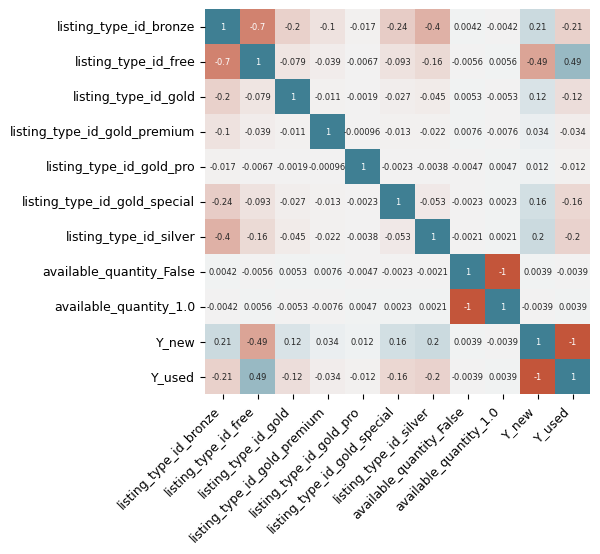

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.heatmap(num_c_matrix,
            annot=True,
            cbar=False,
            annot_kws={"size": 6},
            vmin=-1,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=ax)

ax.set_xticklabels(ax.get_xticklabels(),
                   rotation = 45,
                   horizontalalignment = 'right')

ax.tick_params(labelsize = 9)

Verificando las correlaciones de las diferentes variables no se observan grandes correlaciones salvo, de la variable "listing_type_id_free", aunque la correlación no significa causalidad puede ser una variable que aporte a la clasificación con un conocimiento mas detallado del negocio se podría explicar este comportamientos salvo

####  PCA para la variable "title"

In [85]:
spacy.prefer_gpu()
model = spacy.load("es_core_news_sm")

In [86]:
pipeline = spacy_cleaner.Pipeline(model,
                                  removers.remove_stopword_token,
                                  removers.remove_punctuation_token,
                                  removers.remove_number_token)

In [87]:
def lower_text(text_int):
    temp1 = text_int.split()
    temp2 = [text.lower() for text in temp1]
    text_upper = ' '.join(temp2)
    
    return text_upper   

In [88]:
df_text["title"] = df_text["title"].apply(lambda x: lower_text(x))
df_text["title"] = df_text["title"].apply(lambda x: [x])

In [ ]:
df_text["clean_text"] = [pipeline.clean(text, batch_size=5, n_process=10) for text in df_text["title"]]

Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Cleaning Progress: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Cleaning Progress:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df_text.head()

In [ ]:
df_text.to_csv(FOLDER + "df_text_clean.csv")

In [ ]:
spacy_tokenizer = Tokenizer(model.vocab)
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)

In [ ]:
df_text["pca"] = [tfidf_vector.fit_transform(text) for text in df_text["clean_text"]]

In [ ]:
df_text.to_csv(FOLDER + "df_text_clean_tfidf.csv")